<a href="https://colab.research.google.com/github/diegolestani/s2s/blob/main/S2S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# More on the How: Fundamentals of Survey-to-Survey Imputation

# **0. Setup**

It takes a while. Please run this section asap.

In [3]:
install.packages(c("glmnet","transport","xgboost"))
library(glmnet)
library(ggplot2)
library(transport)
library(xgboost)
library(Matrix)
library(dplyr)



Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘dplyr’


The following object is masked from ‘package:xgboost’:

    slice


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# **1. Creating a toy (yet realistic) dataset**

Set seed for reproducibility and simulate raw variables

In [6]:
set.seed(1729)
n <- 1000

age             <- sample(18:79, n, replace = TRUE)
age_sq          <- age^2
house_ownership <- rbinom(n, 1, 0.6)   # 1 = owns house
employed    <- rbinom(n, 1, 0.7)   # 1 = employed
electricity     <- rbinom(n, 1, 0.8)   # 1 = has electricity
wallsbrick <- rbinom(n, 1, 0.75)   # 1 = walls material: brick
roofmetal  <- rbinom(n, 1, 0.25)   # 1 = roof material: brick
floordirt  <- rbinom(n, 1, 0.15)   # 1 = floor material: dirt
areaurban  <- rbinom(n, 1, 0.65)   # 1 = urban
hhsize     <- sample(1:8, n, replace = TRUE)

df <- data.frame(
  age, age_sq, house_ownership, employed, electricity,
  wallsbrick,roofmetal,floordirt,areaurban,hhsize
)

Define "actual" coefficients

In [7]:
base_coeffs <- c(
  age             = 0.3,
  age_sq          = -0.002,
  house_ownership = 5,
  employed    = 10,
  electricity     = 8,
  wallsbrick     =3,
  roofmetal     = 4,
  floordirt     = -5,
  areaurban    =7
)

Simulate normal random noise and create per capita consumption

In [8]:
noise=rnorm(n,sd=3) #alternative for normal noise
#noise=rexp(n, rate = 1/10) - 10
base_coeffs = matrix(base_coeffs,ncol=1)

#df$consumption_pc=exp(B_0 + as.matrix(df)%*%base_coeffs+noise) #alternative for normal noise
df$consumption_pc=as.matrix(df[,-10])%*%base_coeffs+noise

head(df)

age age_sq house_ownership employed electricity wallsbrick roofmetal
1 36  1296   1               1        1           0          0        
2 75  5625   1               0        0           0          1        
3 59  3481   0               0        1           0          0        
4 62  3844   1               0        1           1          1        
5 78  6084   1               1        1           0          0        
6 60  3600   1               0        1           0          0        
  floordirt areaurban hhsize consumption_pc
1 0         1         5      47.08274      
2 0         0         4      24.71662      
3 0         1         5      23.80194      
4 0         0         7      34.28391      
5 0         0         2      36.81708      
6 1         0         5      16.65397

Visualize the density plot

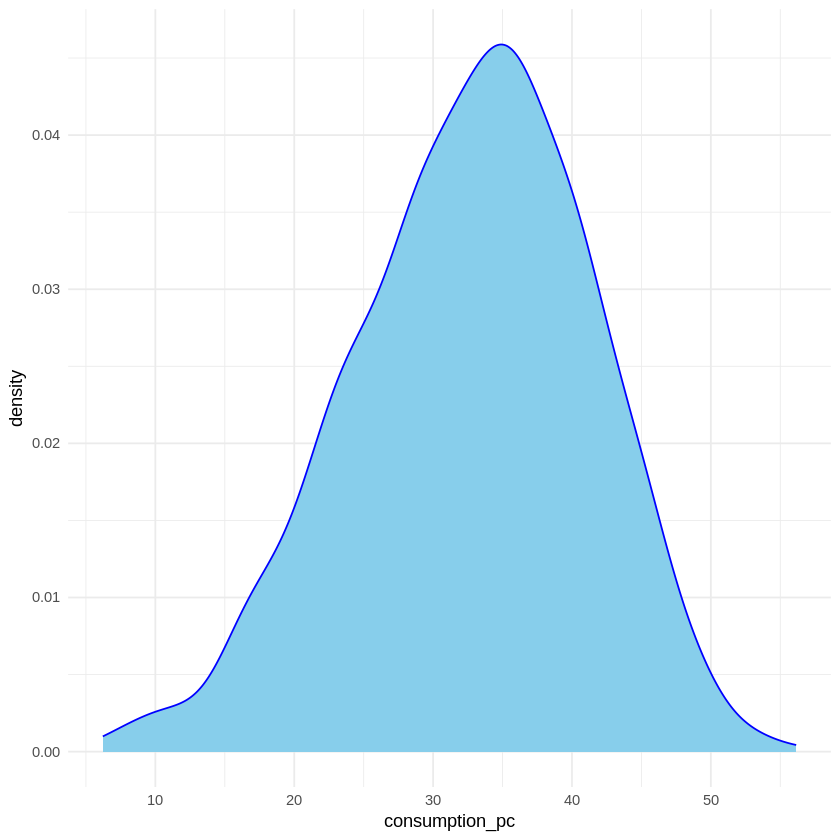

In [9]:
ggplot(df, aes(x = consumption_pc)) +
  geom_density(fill = "skyblue", color = "blue") +
  theme_minimal()

# 2. Bring your best hat
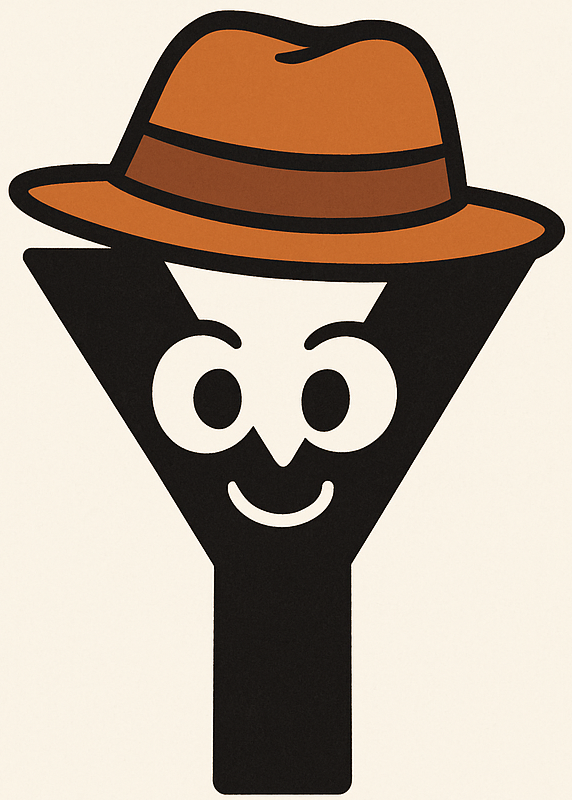

Adjust linear model for consumption_pc

In [10]:
mod0=lm(consumption_pc ~ . , df)
summary(mod0)


Call:
lm(formula = consumption_pc ~ ., data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.5219 -2.1111 -0.0015  2.1474 10.4809 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -0.4658529  0.8659668  -0.538   0.5907    
age              0.3464329  0.0343914  10.073  < 2e-16 ***
age_sq          -0.0024484  0.0003493  -7.009 4.42e-12 ***
house_ownership  5.3012129  0.2046360  25.906  < 2e-16 ***
employed         9.7824611  0.2184844  44.774  < 2e-16 ***
electricity      8.0676693  0.2421746  33.313  < 2e-16 ***
wallsbrick       2.7564545  0.2361947  11.670  < 2e-16 ***
roofmetal        3.9077429  0.2282626  17.120  < 2e-16 ***
floordirt       -4.7647497  0.2733742 -17.429  < 2e-16 ***
areaurban        7.1307734  0.2133029  33.430  < 2e-16 ***
hhsize          -0.0999960  0.0439585  -2.275   0.0231 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.177 on 989 degrees of freedom
Multipl

Visualize residuals

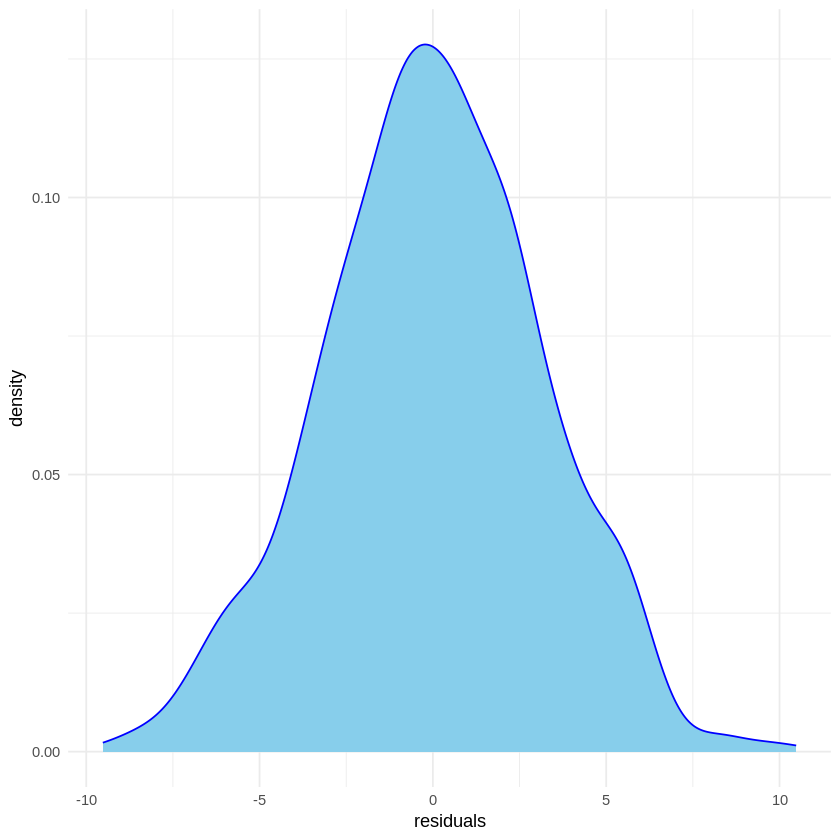

In [11]:
df$residuals = mod0$residuals

ggplot(df, aes(x = residuals)) +
  geom_density(fill = "skyblue", color = "blue") +
  theme_minimal()


How does the prediction look compared to the actual distribution?

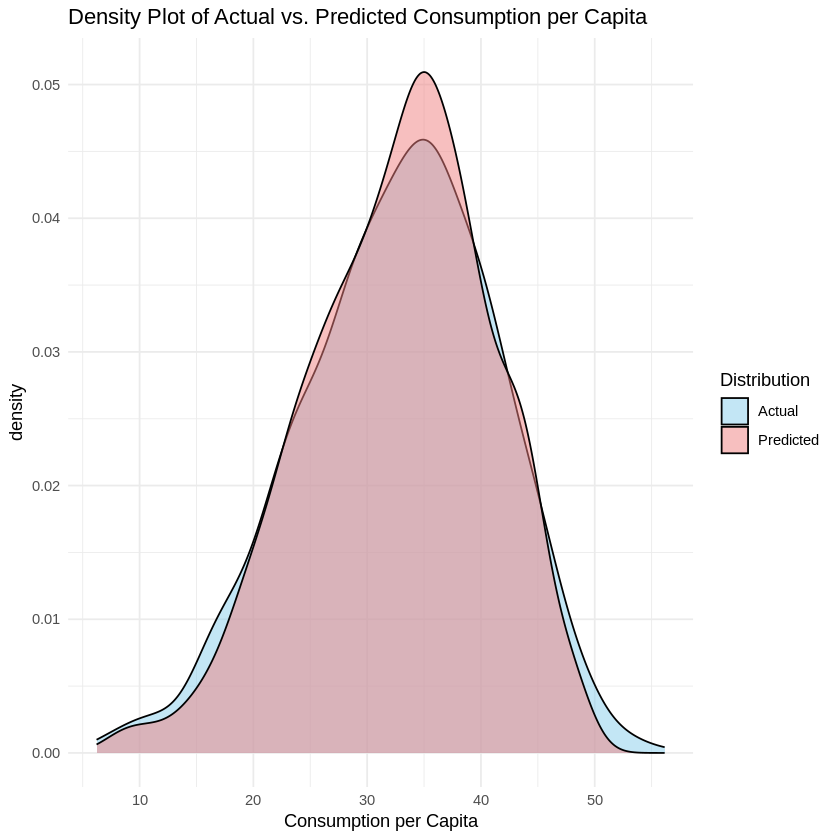

In [12]:
df$predicted <- predict(mod0)

ggplot(df, aes(x = consumption_pc)) +
  geom_density(aes(fill = "Actual"), alpha = 0.5) +
  geom_density(aes(x = predicted, fill = "Predicted"), alpha = 0.5) +
  scale_fill_manual(values = c("Actual" = "skyblue", "Predicted" = "lightcoral")) +
  theme_minimal() +
  labs(title = "Density Plot of Actual vs. Predicted Consumption per Capita",
       x = "Consumption per Capita",
       fill = "Distribution")

More realistic: dropping a **few** covariates

In [13]:
mod1=lm(consumption_pc ~ age+age_sq+areaurban +electricity+house_ownership+roofmetal+hhsize, df)
summary(mod1)


Call:
lm(formula = consumption_pc ~ age + age_sq + areaurban + electricity + 
    house_ownership + roofmetal + hhsize, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-17.400  -3.999   1.032   4.308  14.015 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      7.3841255  1.5255948   4.840 1.50e-06 ***
age              0.3560379  0.0634339   5.613 2.58e-08 ***
age_sq          -0.0025366  0.0006443  -3.937 8.83e-05 ***
areaurban        7.3418369  0.3931908  18.672  < 2e-16 ***
electricity      8.1036381  0.4470241  18.128  < 2e-16 ***
house_ownership  5.0879809  0.3775683  13.476  < 2e-16 ***
roofmetal        3.5441613  0.4207732   8.423  < 2e-16 ***
hhsize          -0.0780139  0.0811134  -0.962    0.336    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.865 on 992 degrees of freedom
Multiple R-squared:  0.5325,	Adjusted R-squared:  0.5292 
F-statistic: 161.4 on 7 and 992 DF,  p-value:

Visualize residuals

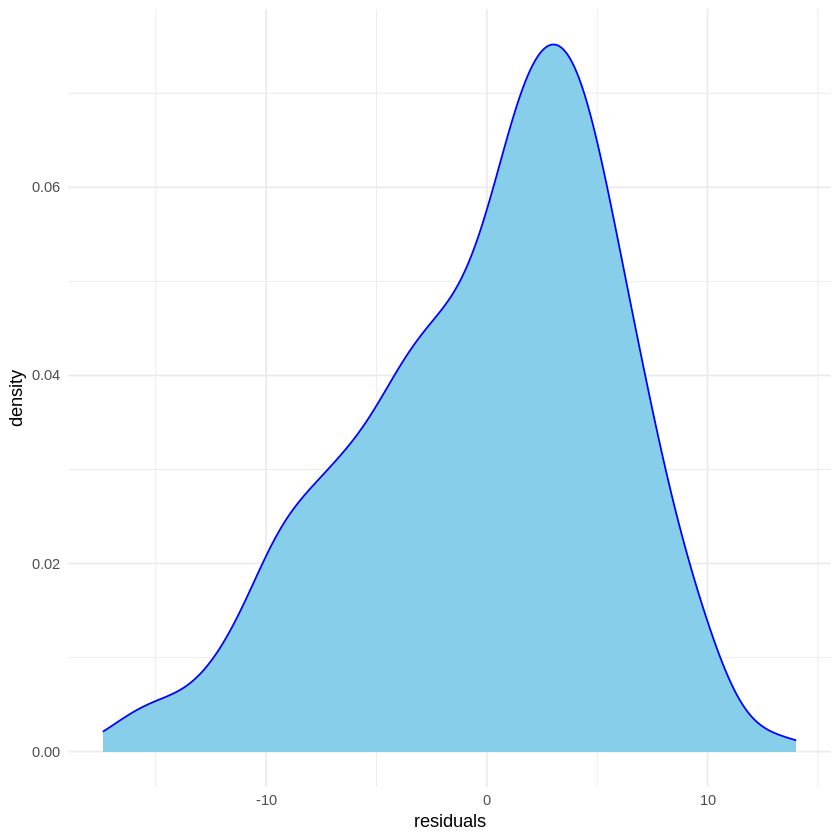

In [14]:
df$residuals = mod1$residuals

ggplot(df, aes(x = residuals)) +
  geom_density(fill = "skyblue", color = "blue") +
  theme_minimal()

And the prediction...

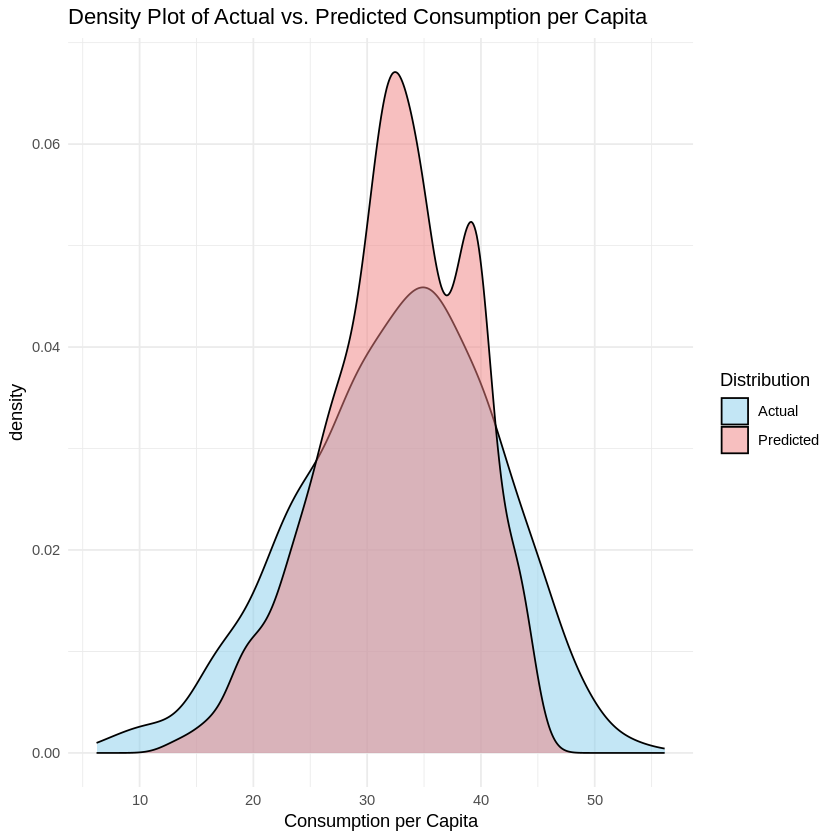

In [15]:
df$predicted <- predict(mod1)

ggplot(df, aes(x = consumption_pc)) +
  geom_density(aes(fill = "Actual"), alpha = 0.5) +
  geom_density(aes(x = predicted, fill = "Predicted"), alpha = 0.5) +
  scale_fill_manual(values = c("Actual" = "skyblue", "Predicted" = "lightcoral")) +
  theme_minimal() +
  labs(title = "Density Plot of Actual vs. Predicted Consumption per Capita",
       x = "Consumption per Capita",
       fill = "Distribution")

Estimating poverty rate. Assume poverty line = 32.

In [16]:
# Actual
cat("Actual poverty rate: ",mean(df$consumption_pc<32),"\n")

# Predicted
cat("Predicted poverty rate: ",mean(df$predicted<32))

Actual poverty rate:  0.444 
Predicted poverty rate:  0.437

Good enough. What if poverty line = 27

In [17]:
# Actual
cat("Actual poverty rate: ",mean(df$consumption_pc<27),"\n")

# Predicted
cat("Predicted poverty rate: ",mean(df$predicted<27))

Actual poverty rate:  0.251 
Predicted poverty rate:  0.181

Uh-oh. Something went wrong. Let's explore.

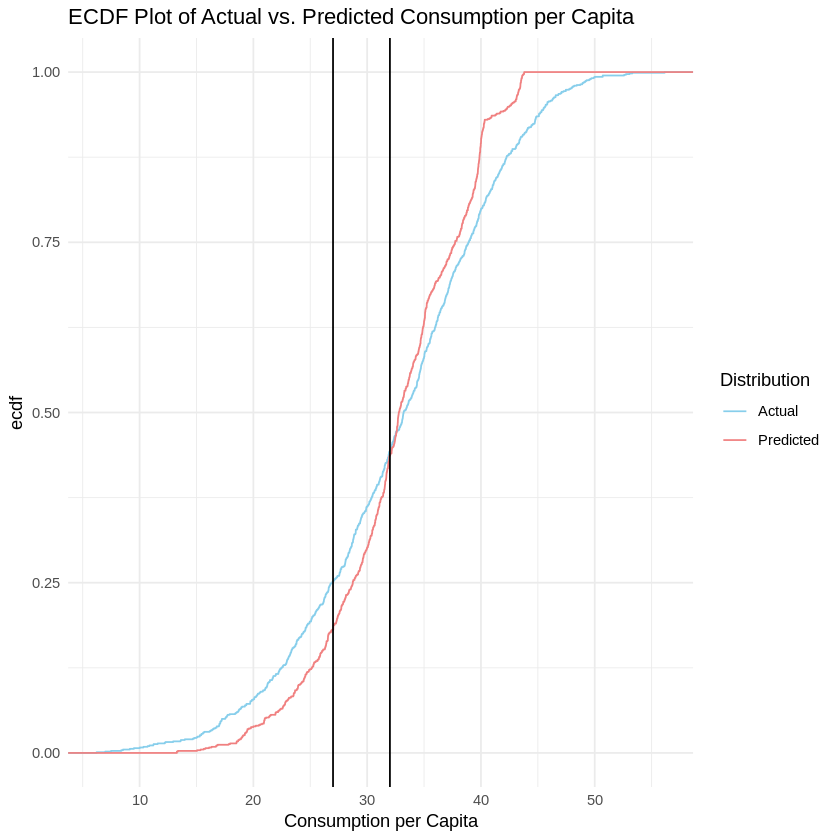

In [18]:
ggplot(df, aes(x = consumption_pc)) +
  stat_ecdf(aes(color = "Actual")) +
  stat_ecdf(aes(x = predicted, color = "Predicted")) +
  scale_color_manual(values = c("Actual" = "skyblue", "Predicted" = "lightcoral")) +
  theme_minimal() +
  geom_vline(xintercept =27)+
  geom_vline(xintercept =32)+
  labs(title = "ECDF Plot of Actual vs. Predicted Consumption per Capita",
       x = "Consumption per Capita",
       color = "Distribution")

Let's try to get a better hat using stepwise selection

In [19]:
mod2=step(mod1)
summary(mod2)

Start:  AIC=3545.85
consumption_pc ~ age + age_sq + areaurban + electricity + house_ownership + 
    roofmetal + hhsize

                  Df Sum of Sq   RSS    AIC
- hhsize           1      31.8 34151 3544.8
<none>                         34119 3545.8
- age_sq           1     533.1 34652 3559.4
- age              1    1083.5 35202 3575.1
- roofmetal        1    2440.1 36559 3612.9
- house_ownership  1    6245.7 40365 3712.0
- electricity      1   11302.6 45421 3830.0
- areaurban        1   11991.8 46111 3845.0

Step:  AIC=3544.78
consumption_pc ~ age + age_sq + areaurban + electricity + house_ownership + 
    roofmetal

                  Df Sum of Sq   RSS    AIC
<none>                         34151 3544.8
- age_sq           1     530.1 34681 3558.2
- age              1    1077.6 35228 3573.8
- roofmetal        1    2437.4 36588 3611.7
- house_ownership  1    6287.1 40438 3711.8
- electricity      1   11364.9 45516 3830.1
- areaurban        1   11966.8 46117 3843.2



Call:
lm(formula = consumption_pc ~ age + age_sq + areaurban + electricity + 
    house_ownership + roofmetal, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-17.521  -4.042   1.137   4.235  14.119 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      7.0582416  1.4874361   4.745 2.39e-06 ***
age              0.3550098  0.0634225   5.598 2.81e-08 ***
age_sq          -0.0025293  0.0006442  -3.926 9.23e-05 ***
areaurban        7.3313414  0.3930245  18.654  < 2e-16 ***
electricity      8.1200231  0.4466825  18.179  < 2e-16 ***
house_ownership  5.1013422  0.3772984  13.521  < 2e-16 ***
roofmetal        3.5421459  0.4207521   8.419  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.864 on 993 degrees of freedom
Multiple R-squared:  0.5321,	Adjusted R-squared:  0.5292 
F-statistic: 188.2 on 6 and 993 DF,  p-value: < 2.2e-16


In [20]:
df$predicted <- predict(mod2)
# Actual
cat("Actual poverty rate: ",mean(df$consumption_pc<27),"\n")

# Predicted
cat("Predicted poverty rate: ",mean(df$predicted<27))


Actual poverty rate:  0.251 
Predicted poverty rate:  0.186

One more try. Let's lasso it.
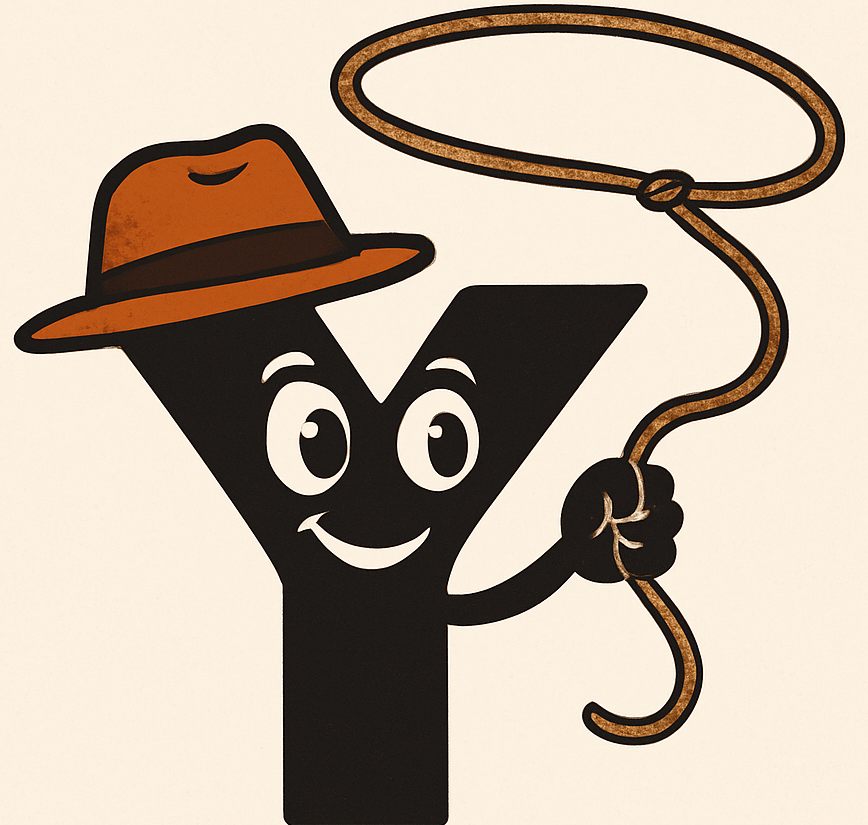

In [21]:
x <- model.matrix(consumption_pc ~ age+age_sq+areaurban +electricity+house_ownership+roofmetal, df)[,-1]
y <- df$consumption_pc
lasso_mod <- glmnet(x, y, alpha = 1)
df$predicted_lasso <- predict(lasso_mod, newx = x, s = min(lasso_mod$lambda)) # Use the minimum lambda

# Actual
cat("Actual poverty rate: ",mean(df$consumption_pc<27),"\n")

# Predicted Lasso
cat("Predicted lasso poverty rate: ",mean(df$predicted_lasso<27))

Actual poverty rate:  0.251 
Predicted lasso poverty rate:  0.186

Not quite. How about the distribution

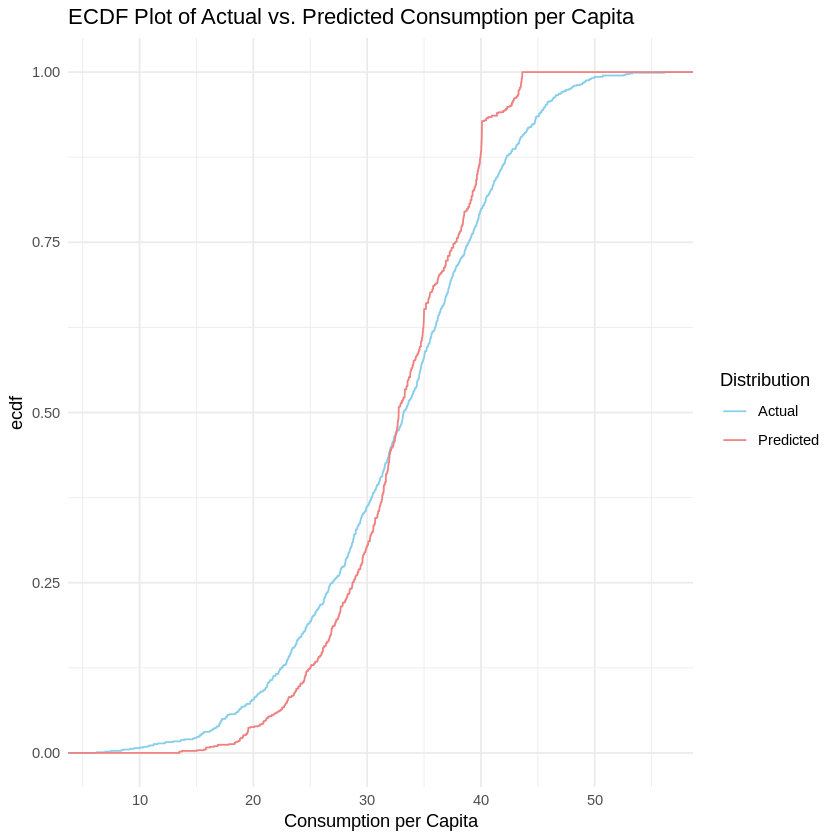

In [22]:
ggplot(df, aes(x = consumption_pc)) +
  stat_ecdf(aes(color = "Actual")) +
  stat_ecdf(aes(x = predicted_lasso, color = "Predicted")) +
  scale_color_manual(values = c("Actual" = "skyblue", "Predicted" = "lightcoral")) +
  theme_minimal() +
  labs(title = "ECDF Plot of Actual vs. Predicted Consumption per Capita",
       x = "Consumption per Capita",
       color = "Distribution")

Root mean square error

In [23]:
# Function to calculate RMSE
rmse <- function(actual, predicted) {
  sqrt(mean((actual - predicted)^2))
}

# Calculate RMSE for mod2
rmse_mod2 <- rmse(df$consumption_pc, df$predicted)
cat("RMSE for mod2:", rmse_mod2, "\n")

# Calculate RMSE for lasso_mod
rmse_lasso <- rmse(df$consumption_pc, df$predicted_lasso)
cat("RMSE for lasso_mod:", rmse_lasso, "\n")

RMSE for mod2: 5.843852 
RMSE for lasso_mod: 5.844085 


R-squared

In [24]:
# Function to calculate R-squared
rsquared <- function(actual, predicted) {
  rss <- sum((actual - predicted)^2)
  tss <- sum((actual - mean(actual))^2)
  1 - (rss / tss)
}

# Calculate R-squared for mod2
rsquared_mod2 <- rsquared(df$consumption_pc, df$predicted)
cat("R-squared for mod2:", rsquared_mod2, "\n")

# Calculate R-squared for lasso_mod
rsquared_lasso <- rsquared(df$consumption_pc, df$predicted_lasso)
cat("R-squared for lasso_mod:", rsquared_lasso, "\n")

#add comment to try github

R-squared for mod2: 0.5320558 
R-squared for lasso_mod: 0.5320186 


Negligible differences: mod2 is still our champion but let's try some ML
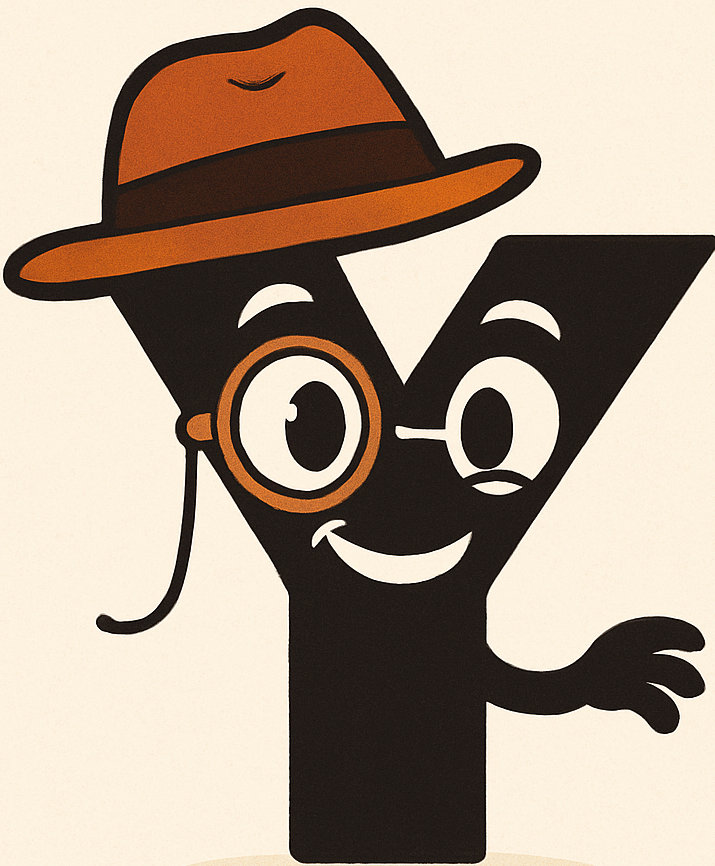


XGBoost is a quick reliable choice

[1]	train-rmse:23.795445 
[2]	train-rmse:17.262815 
[3]	train-rmse:12.825888 
[4]	train-rmse:9.886256 
[5]	train-rmse:7.978350 
[6]	train-rmse:6.804991 
[7]	train-rmse:6.091727 
[8]	train-rmse:5.676713 
[9]	train-rmse:5.427336 
[10]	train-rmse:5.281241 
[11]	train-rmse:5.181540 
[12]	train-rmse:5.123751 
[13]	train-rmse:5.070011 
[14]	train-rmse:5.018049 
[15]	train-rmse:4.980529 
[16]	train-rmse:4.933070 
[17]	train-rmse:4.909331 
[18]	train-rmse:4.888394 
[19]	train-rmse:4.849068 
[20]	train-rmse:4.833671 
[21]	train-rmse:4.789969 
[22]	train-rmse:4.774933 
[23]	train-rmse:4.761105 
[24]	train-rmse:4.736353 
[25]	train-rmse:4.731728 
[26]	train-rmse:4.721079 
[27]	train-rmse:4.718027 
[28]	train-rmse:4.698494 
[29]	train-rmse:4.679849 
[30]	train-rmse:4.664370 
[31]	train-rmse:4.662372 
[32]	train-rmse:4.660020 
[33]	train-rmse:4.627831 
[34]	train-rmse:4.619708 
[35]	train-rmse:4.596804 
[36]	train-rmse:4.595304 
[37]	train-rmse:4.587884 
[38]	train-rmse:4.572080 
[39]	train-rmse:4.

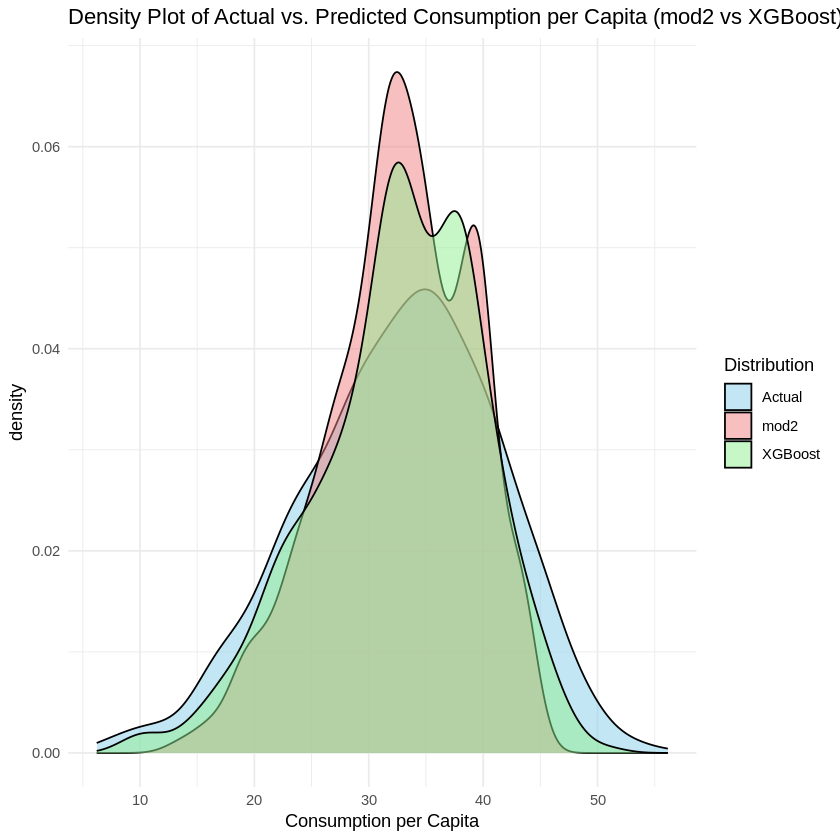

In [25]:
# Prepare data for XGBoost
features <- df[, c("age","age_sq","areaurban","electricity","house_ownership","roofmetal")]
# Convert the dataframe to a matrix, which is required by xgboost
feature_matrix <- as.matrix(features)
# Create the DMatrix object
dtrain <- xgb.DMatrix(data = feature_matrix, label = df$consumption_pc)

# Define XGBoost parameters
params <- list(
  objective = "reg:squarederror", # Regression objective
  eval_metric = "rmse"           # Evaluation metric
)

# Train the XGBoost model
xgb_mod <- xgboost(data = dtrain, params = params, nrounds = 100)

# Generate predictions using the XGBoost model
df$predicted_xgb <- predict(xgb_mod, dtrain)

# Comparison metrics
# Density plot
ggplot(df, aes(x = consumption_pc)) +
  geom_density(aes(fill = "Actual"), alpha = 0.5) +
  geom_density(aes(x = predicted, fill = "mod2"), alpha = 0.5) +
  geom_density(aes(x = predicted_xgb, fill = "XGBoost"), alpha = 0.5) +
  scale_fill_manual(values = c("Actual" = "skyblue", "mod2" = "lightcoral", "XGBoost" = "lightgreen")) +
  theme_minimal() +
  labs(title = "Density Plot of Actual vs. Predicted Consumption per Capita (mod2 vs XGBoost)",
       x = "Consumption per Capita",
       fill = "Distribution")

# Poverty rate comparison (using poverty line = 27)
cat("Actual poverty rate: ",mean(df$consumption_pc<27),"\n")
cat("Predicted mod2 poverty rate: ",mean(df$predicted<27),"\n")
cat("Predicted XGBoost poverty rate: ",mean(df$predicted_xgb<27),"\n")

# R-squared comparison
rsquared_xgb <- rsquared(df$consumption_pc, df$predicted_xgb)
cat("R-squared for mod2:", rsquared_mod2, "\n")
cat("R-squared for XGBoost:", rsquared_xgb, "\n")

# RMSE comparison
rmse_xgb <- rmse(df$consumption_pc, df$predicted_xgb)
cat("RMSE for mod2:", rmse_mod2, "\n")
cat("RMSE for XGBoost:", rmse_xgb, "\n")

Not there yet, but let's take a look at the residuals anyway

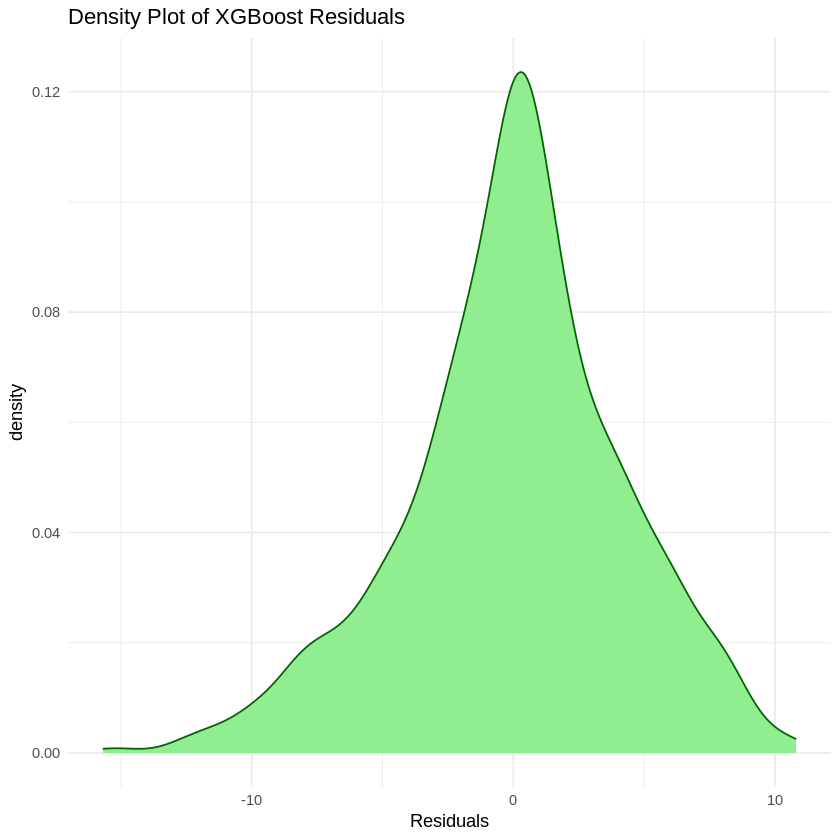

In [26]:
df$residuals_xgb = df$consumption_pc - df$predicted_xgb

ggplot(df, aes(x = residuals_xgb)) +
  geom_density(fill = "lightgreen", color = "darkgreen") +
  theme_minimal() +
  labs(title = "Density Plot of XGBoost Residuals",
       x = "Residuals")

# **3. Complement your hat with a noise jacket**
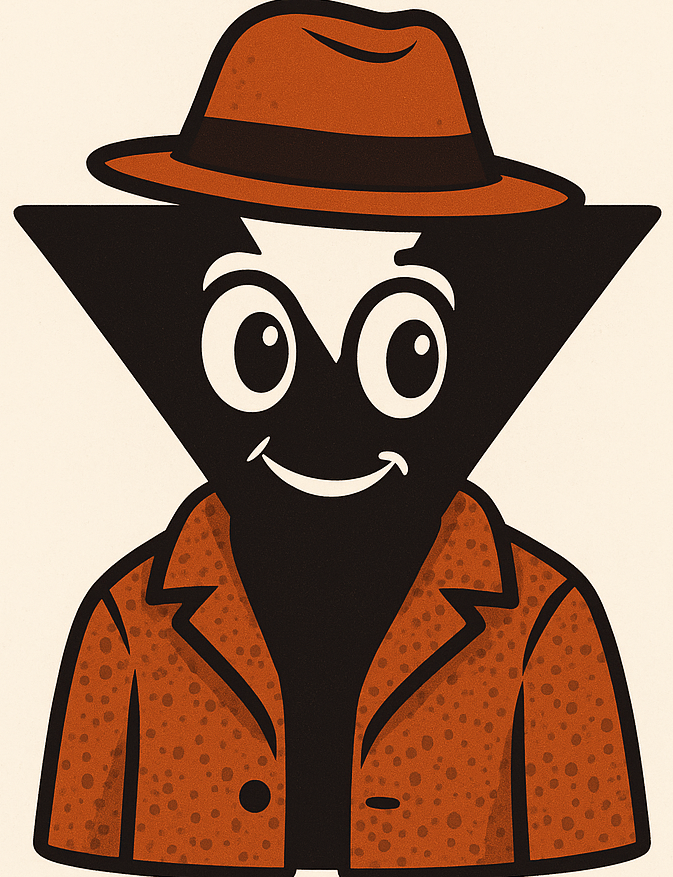

Adding normal random noise and calculating the poverty rate

In [28]:
df$prediction_plus_noise <- predict(mod2) + rnorm(n, sd = summary(mod2)$sigma)

cat("Predicted mod2 plus noise poverty rate: ",mean(df$prediction_plus_noise<27))

Predicted mod2 plus noise poverty rate:  0.241

Promising. Now let's check the distributions.

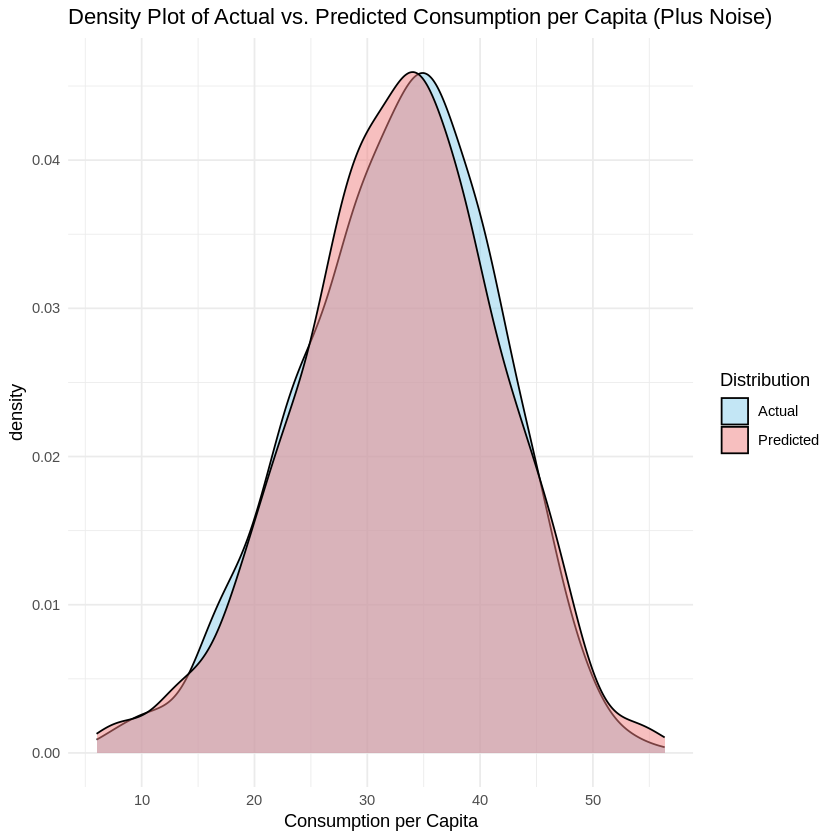

In [29]:
ggplot(df, aes(x = consumption_pc)) +
  geom_density(aes(fill = "Actual"), alpha = 0.5) +
  geom_density(aes(x = prediction_plus_noise, fill = "Predicted"), alpha = 0.5) +
  scale_fill_manual(values = c("Actual" = "skyblue", "Predicted" = "lightcoral")) +
  theme_minimal() +
  labs(title = "Density Plot of Actual vs. Predicted Consumption per Capita (Plus Noise)",
       x = "Consumption per Capita",
       fill = "Distribution")

 Looks good. Let's do it more times and see how poverty rates look

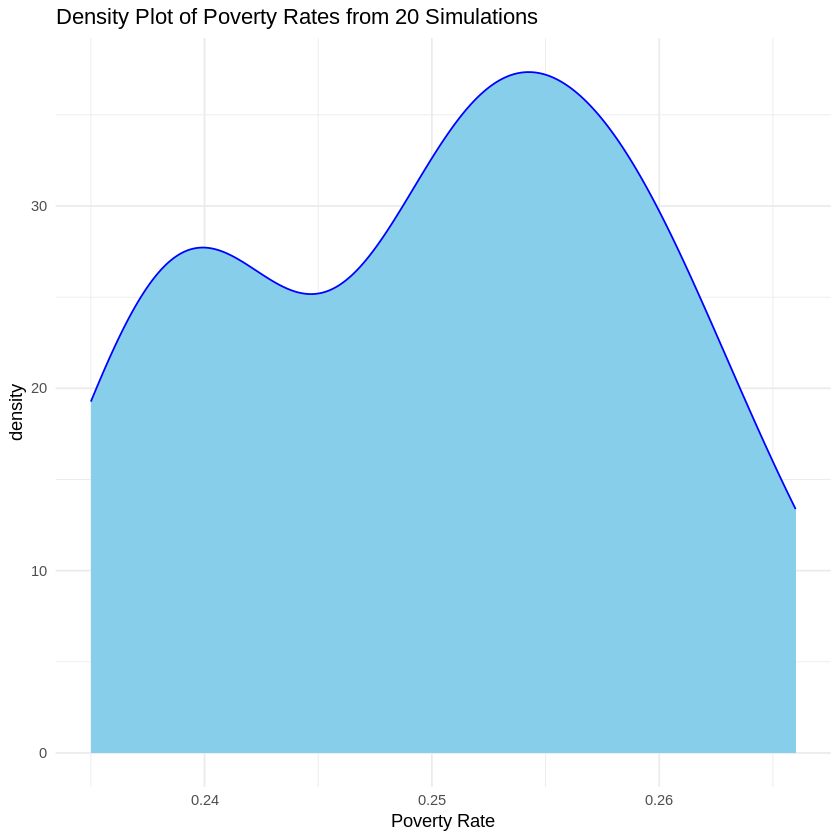

In [30]:
simulations <- 20
poverty_rates <- numeric(simulations)
predicted_consumption_list <- list()

for (i in 1:simulations) {
  df$prediction_plus_noise <- predict(mod2) + rnorm(n, sd = summary(mod2)$sigma)
  poverty_rates[i] <- mean(df$prediction_plus_noise < 27)
  predicted_consumption_list[[i]] <- df$prediction_plus_noise
}

# Create a data frame for the poverty rates from simulations
poverty_rates_df <- data.frame(poverty_rate = poverty_rates)

# Plot the density of the poverty rates
ggplot(poverty_rates_df, aes(x = poverty_rate)) +
  geom_density(fill = "skyblue", color = "blue") +
  theme_minimal() +
  labs(title = "Density Plot of Poverty Rates from 20 Simulations",
       x = "Poverty Rate")

And the average poverty rate

In [31]:
cat("Average predicted poverty rate:", mean(poverty_rates), "\n")

Average predicted poverty rate: 0.25015 


But we need one predicted vector. Let's average across simulations

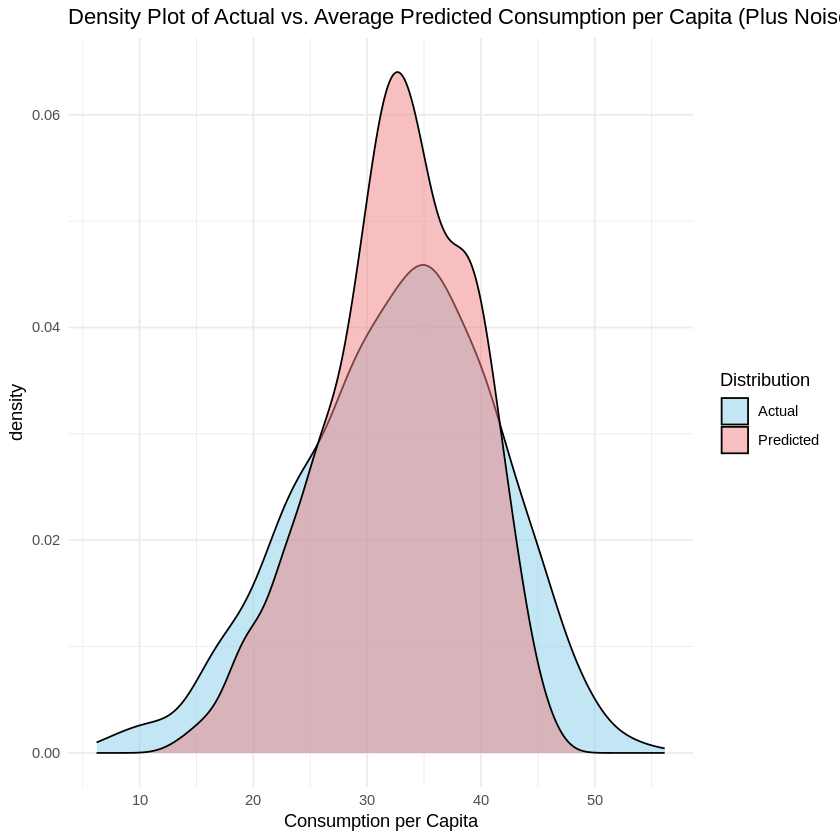

In [32]:
# Average the predicted consumption across simulations
df$avg_predicted_consumption <- rowMeans(do.call(cbind, predicted_consumption_list))

ggplot(df, aes(x = consumption_pc)) +
  geom_density(aes(fill = "Actual"), alpha = 0.5) +
  geom_density(aes(x = avg_predicted_consumption, fill = "Predicted"), alpha = 0.5) +
  scale_fill_manual(values = c("Actual" = "skyblue", "Predicted" = "lightcoral")) +
  theme_minimal() +
  labs(title = "Density Plot of Actual vs. Average Predicted Consumption per Capita (Plus Noise)",
       x = "Consumption per Capita",
       fill = "Distribution")


Low expectations here, but let’s take a look at the poverty rate

In [33]:
cat("Poverty rate based on average predicted consumption:", mean(df$avg_predicted_consumption < 27), "\n")

Poverty rate based on average predicted consumption: 0.192 


Not again!

OK. Let's try something else. How do we choose one out the 20 simulations?

Debate: Why R-squared or RMSE would not solve our problem?

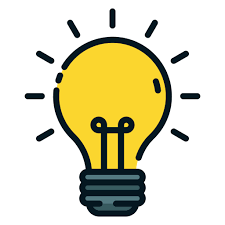

Let's choose the one that more closely resembles the original distribution.

First, let's define the distributional metric ->  Wasserstein distance (Kantorovich–Rubinstein metric)

In [35]:
compute_wasserstein_distance <- function(original, predicted_matrix) {
  distances <- apply(predicted_matrix, 2, function(pred) {
    wasserstein1d(original, pred)
  })
  return(distances)
}

Now we will calculate the distributional distance between every simulation and the original vector and choose the closest one.

Poverty rate for the closest simulation: 0.243 


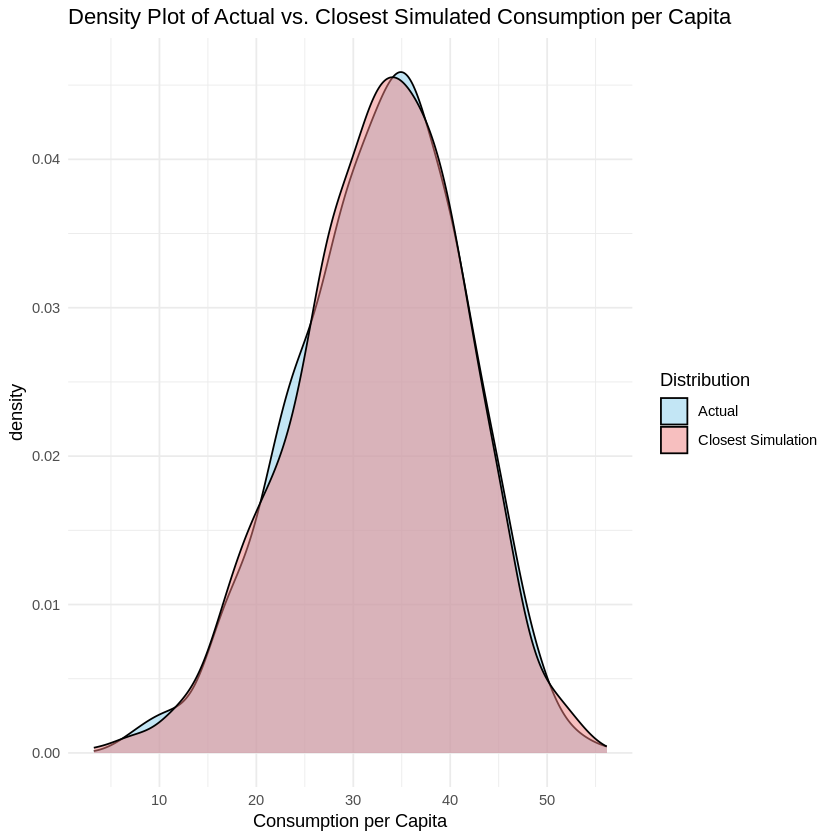

In [41]:
distances <- compute_wasserstein_distance(df$consumption_pc, do.call(cbind, predicted_consumption_list))
closest_simulation_index <- which.min(distances)
closest_predicted_consumption <- predicted_consumption_list[[closest_simulation_index]]

# Add the closest predicted consumption vector to the data frame
df$closest_predicted_consumption <- closest_predicted_consumption

# Compare the distribution of the closest simulation with the actual data
ggplot(df, aes(x = consumption_pc)) +
  geom_density(aes(fill = "Actual"), alpha = 0.5) +
  geom_density(aes(x = closest_predicted_consumption, fill = "Closest Simulation"), alpha = 0.5) +
  scale_fill_manual(values = c("Actual" = "skyblue", "Closest Simulation" = "lightcoral")) +
  theme_minimal() +
  labs(title = "Density Plot of Actual vs. Closest Simulated Consumption per Capita",
       x = "Consumption per Capita",
       fill = "Distribution")

# Check the poverty rate for the closest simulation
cat("Poverty rate for the closest simulation:", mean(df$closest_predicted_consumption < 27), "\n")

# 4. A little beyond: Bootstrapping
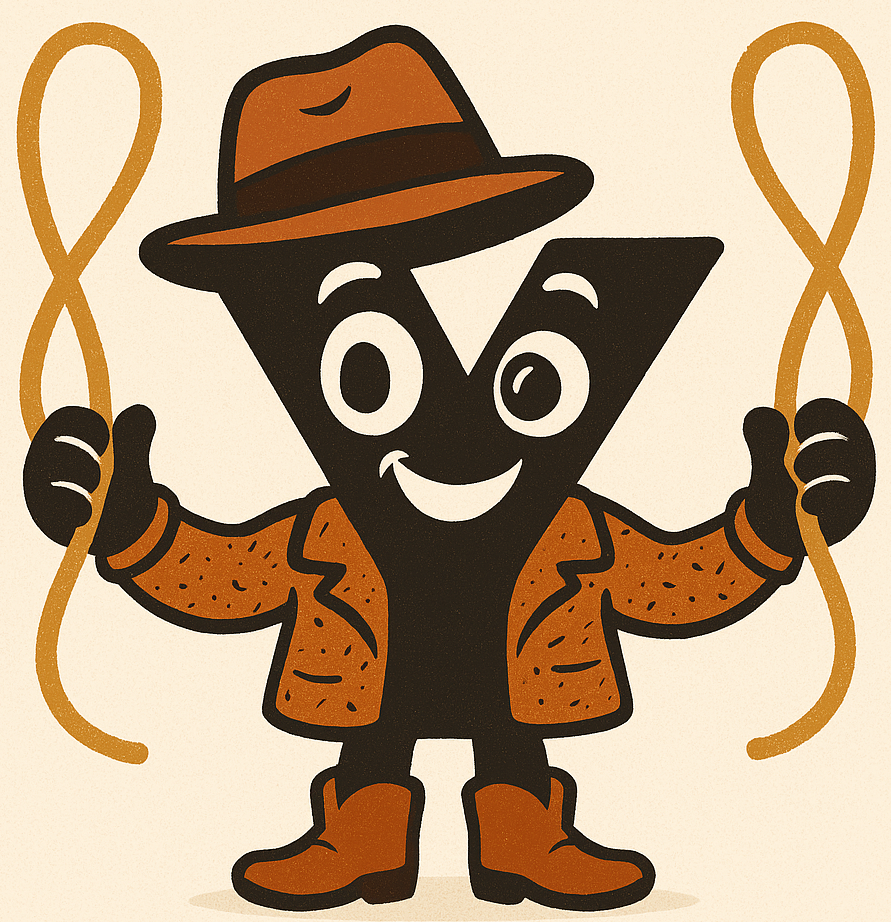

Non-parametric bootstrapping: generate 20 prediction + noise vectors trained on subsamples (80%), select closest via Wasserstein distance, compute poverty rate, and plot density


In [48]:
# Number of simulations
simulations <- 20
predicted_consumption_list <- list()
#actual_consumption <- df$consumption_pc # Store the actual consumption vector

for (i in 1:simulations) {
  # Take a random sample of 80% of the data
  sample_indices <- sample(1:nrow(df), size = floor(0.8 * nrow(df)), replace = FALSE)
  df_sample <- df[sample_indices, ]

  # Adjust a lm with the same covariates as in mod2 using the sample
  # Assuming mod2 is already defined and has the formula you need
  mod_sample <- lm(formula(mod2), data = df_sample)

  # Predict consumption_pc for the original df
  predictions <- predict(mod_sample, newdata = df)

  # Calculate the residuals for the sample
  residuals_sample <- residuals(mod_sample)

  # Take a random sample of the residuals of the same length as the original df
  # Bootstrapping residuals to match the length of the original data
  residual_noise <- sample(residuals_sample, size = nrow(df), replace = TRUE)

  # Generate a prediction plus noise
  prediction_plus_noise <- predictions + residual_noise

  # Keep the final vector
  predicted_consumption_list[[i]] <- prediction_plus_noise
}

# Use the wasserstein distance to determine which of the 20 simulations has the closest distribution to the actual one
distances <- compute_wasserstein_distance(df$consumption_pc, do.call(cbind, predicted_consumption_list))
closest_simulation_index <- which.min(distances)
closest_predicted_consumption <- predicted_consumption_list[[closest_simulation_index]]

# Calculate the poverty rate with that one
poverty_rate_closest <- mean(closest_predicted_consumption < 27)
cat("Poverty rate for the closest simulation:", poverty_rate_closest, "\n")

# Generate the density plot to compare the actual and predicted plus noise distributions
plot_df <- data.frame(
  consumption = c(actual_consumption, closest_predicted_consumption),
  type = factor(rep(c("Actual", "Closest Simulation"), each = length(actual_consumption)))
)

ggplot(plot_df, aes(x = consumption, fill = type)) +
  geom_density(alpha = 0.5) +
  scale_fill_manual(values = c("Actual" = "skyblue", "Closest Simulation" = "lightcoral")) +
  theme_minimal() +
  labs(title = "Density Plot of Actual vs. Closest Simulated Consumption per Capita",
       x = "Consumption per Capita",
       fill = "Distribution")

Poverty rate for the closest simulation: 0.246 


ERROR: Error: object 'actual_consumption' not found
